## 2017121261 / 소프트웨어학과 / 허태영 / HW#1

#### pytorch lightning Cifar10

pytorch lightning 툴과 Cifar10 dataset을 이용하여 학습하시면 됩니다. model은 자유입니다.

실험 결과(Loss, Accuracy) 는 Weight & Bias 를 이용해주세요. 



제출은 Git 링크와 실험 결과를 로그한 Weight & Bias 링크를 첨부해주면 됩니다.

weight&bias 링크의 프로젝트명은 누군지 알아볼 수 있도록 [학번_이름_과제명]형식으로 작성해주세요.



[Weight & Bias 참조 링크]

https://wandb.ai/wandb_fc/korean/reports/Weights-Biases-Pytorch-Lightning---VmlldzozNzAxOTg

## Library

In [2]:
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# CIFAR-10
from torchvision import datasets, transforms

# Pytorch Lightning
import pytorch_lightning as pl

# WandB
from pytorch_lightning.loggers import WandbLogger

# model module
from src.models.resnet import ResidualBlock

## WandB

In [8]:
wandb_logger = WandbLogger(
    name='hty',
    project='2017121261_TaeyeongHeo_HW1'
)

## Static variables

In [9]:
DATA_DIR='../data' # cifar-10 data is ignored by .gitignore
NUM_CLASSES = 10
NUM_WORKERS = 12
BATCH_SIZE = 64
EPOCHS = 50

## CIFAR-10 DataModule

In [10]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [13]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, train_transform, data_dir='./', batch_size=32, num_workers=8):
        super().__init__()
        self.train_transform = train_transform
        self.val_transform = transforms.ToTensor()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
    
    def prepare_data(self):
        datasets.CIFAR10(root=self.data_dir, train=True, download=True)
        datasets.CIFAR10(root=self.data_dir, train=False, download=True)
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dset = datasets.CIFAR10(root=self.data_dir, train=True,
                                               transform=self.train_transform)
            self.val_dset = datasets.CIFAR10(root=self.data_dir, train=False,
                                             transform=self.val_transform)
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dset, batch_size=self.batch_size,
                                           num_workers=self.num_workers, pin_memory=True)


    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dset, batch_size=self.batch_size,
                                           num_workers=self.num_workers, pin_memory=True)

In [14]:
data_module = CIFAR10DataModule(train_transform,
                                data_dir=DATA_DIR,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS
                                )

In [15]:
data_module.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [16]:
data_module.setup()

## Modeling

In [17]:
@torch.no_grad()
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

def conv_bn(in_channels, out_channels, kernel_size=3, stride=1):
    padding = (kernel_size - 1) // 2
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels)
    )

def residual_body(in_channels, repetitions, strides):
    layers = []
    res_channels = in_channels
    for rep, stride in zip(repetitions, strides):
        for _ in range(rep):
            layers.append(ResidualBlock(in_channels, res_channels, stride))
            in_channels = res_channels
            stride = 1
        res_channels = res_channels * 2
    return nn.Sequential(*layers)

def stem(channel_list, stride):
    layers = []
    for in_channels, out_channels in zip(channel_list, channel_list[1:]):
        layers += [conv_bn(in_channels, out_channels, stride=stride), nn.ReLU(inplace=True)]
        stride = 1
    return nn.Sequential(*layers)

def head(in_channels, classes, p_drop=0.):
    return nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

def resnet(repetitions, classes, strides=None, p_drop=0.):
    if not strides: strides = [2] * (len(repetitions) + 1)
    return nn.Sequential(
        stem([3, 32, 32, 64], strides[0]),
        residual_body(64, repetitions, strides[1:]),
        head(64 * 2**(len(repetitions) - 1), classes, p_drop)
    )

In [18]:
model = resnet([2, 2, 2, 2], NUM_CLASSES, strides=[1, 1, 2, 2, 2], p_drop=0.3)

In [19]:
model.apply(init_linear)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU(inplace=True)
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU(inplace=True)
    (4): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): ResidualBlock(
      (shortcut): Sequential()
      (residual): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-0

In [20]:
from torchmetrics import Accuracy

class ClassificationTask(pl.LightningModule):
    def __init__(self, model, max_lr, epochs, steps_per_epoch):
        super().__init__()
        self.save_hyperparameters('max_lr', 'epochs')
        self.steps_per_epoch = steps_per_epoch
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(compute_on_step=False)
        self.val_acc = Accuracy(compute_on_step=False)
    
    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch, metric, prefix):
        x, y = batch
        logits = self.model(x)
        loss = self.loss(logits, y)
        metric(logits, y)
        self.log(f'{prefix}_loss', loss)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, self.train_acc, 'train')
    
    def training_epoch_end(self, outs):
        self.log('train_acc', self.train_acc.compute())
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, self.val_acc, 'val')
    
    def validation_epoch_end(self, val_outs):
        self.log('val_acc', self.val_acc.compute())
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), weight_decay=1e-2)
        lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.hparams.max_lr,
                                                     steps_per_epoch=self.steps_per_epoch,
                                                     epochs=self.hparams.epochs)
        lr_dict = {'scheduler': lr_scheduler, 'interval': 'step'}
        return [optimizer], [lr_dict]

In [21]:
classifier = ClassificationTask(
    model=model,
    max_lr=1e-2,
    epochs=EPOCHS,
    steps_per_epoch=len(data_module.train_dataloader())
    )

In [27]:
#trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS+1)
trainer = pl.Trainer(
    max_epochs=EPOCHS+1,
    logger=wandb_logger
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
lr_finder = trainer.tuner.lr_filr_finder = trainer.tuner.lr_find(classifier, datamodule=data_module, min_lr=1e-6, max_lr=1e-1)

Files already downloaded and verified
Files already downloaded and verified


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.9/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/usr/lib/python3.9/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/usr/local/lib/python3.9/dist-packages/torch/multiprocessing/reductions.py", line 319, in reduce_storage
    metadata = storage._share_filename_()
  File "/usr/local/lib/python3.9/dist-packages/torch/multiprocessing/reductions.py", line 319, in reduce_storage
    metadata = storage._share_filename_()
RuntimeError: falseINTERNAL ASSERT FAILED at "../aten/src/ATen/MapAllocator.cpp":300, please report a bug to PyTorch. unable to write to file </torch_23618_1>
RuntimeError: falseIN

RuntimeError: DataLoader worker (pid(s) 23643) exited unexpectedly

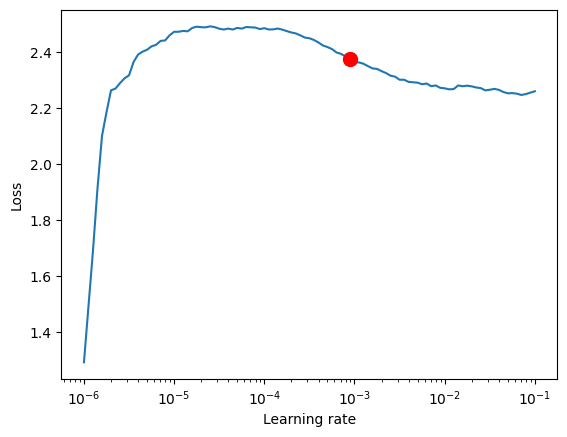

In [24]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [25]:
trainer.fit(classifier, datamodule=data_module)

Files already downloaded and verified
Files already downloaded and verified



  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 11.2 M
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | val_acc   | Accuracy         | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.804    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RuntimeError: value cannot be converted to type float without overflow: -3.54813e+38

In [26]:
trainer.save_checkpoint('model_save.ckpt')